# Clasificación de imágenes con modelos de *ensemble*
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para predecir la clase de imágenes de distintos escenarios.

## 1. Setup

Librerías importadas en el proyecto.

In [1]:
import numpy as np
import pandas as pd

import os
import warnings

from IPython.display import IFrame

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Variables globales declaradas en el proyecto.

In [2]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

DATASETS = ["train", "test"]
CATEGORIES = ["edificios", "glaciares", "montanas", "mares", "bosques", "calles"]

DATA_PATH = os.path.join(os.pardir, "data")  # Path to csv data
INFO_PATH = os.path.join(os.pardir, "info")  # Path to problem info
RESULTS_PATH = os.path.join(os.pardir, "results")  # Path to results files

Enunciado del problema.

In [3]:
IFrame(os.path.join(INFO_PATH, "lab2.pdf"), width=1080, height=920)

## 2. Análisis exploratorio de los datos

En primer lugar, vamos a cargar los datos en memoria.

In [4]:
dataframes = {}

for dataset in DATASETS:
    dataset_path = os.path.join(DATA_PATH, dataset)
    data = []
    for category in os.listdir(dataset_path):
        print(f"Reading category {category} from {dataset} set...")
        category_path = os.path.join(dataset_path, category)
        for file in filter(lambda x: x.endswith(".jpg"), os.listdir(category_path)):
            data.append({
                "img": plt.imread(os.path.join(category_path, file)),
                "label": category
            })
    dataframes[dataset] = pd.DataFrame(data)
    del data

Reading category edificios from train set...
Reading category glaciares from train set...
Reading category montanas from train set...
Reading category mares from train set...
Reading category bosques from train set...
Reading category calles from train set...
Reading category edificios from test set...
Reading category glaciares from test set...
Reading category montanas from test set...
Reading category mares from test set...
Reading category bosques from test set...
Reading category calles from test set...


Con todo cargado en memoria, vamos a hacer una primera visualización de los datos que tenemos. Cogeremos una muestra aleatoria para echar un vistazo a las imágenes.

edificios


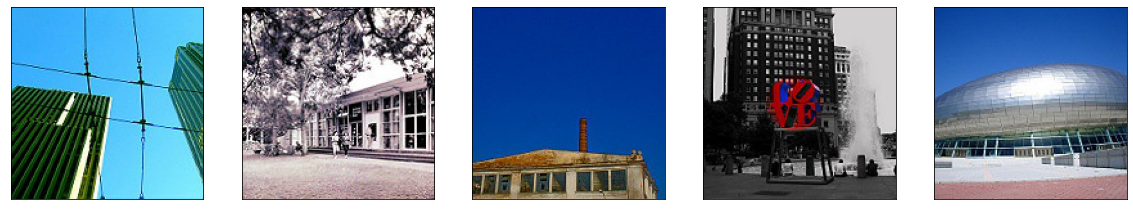

glaciares


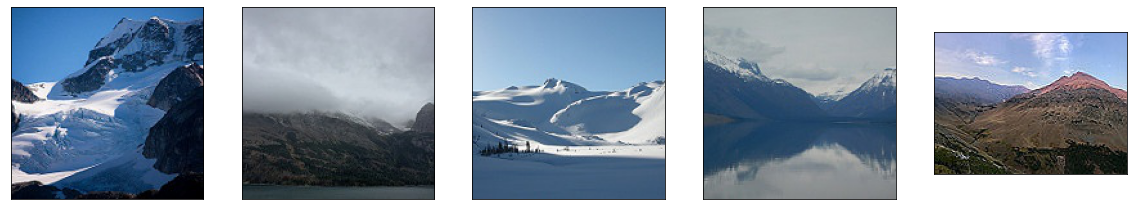

montanas


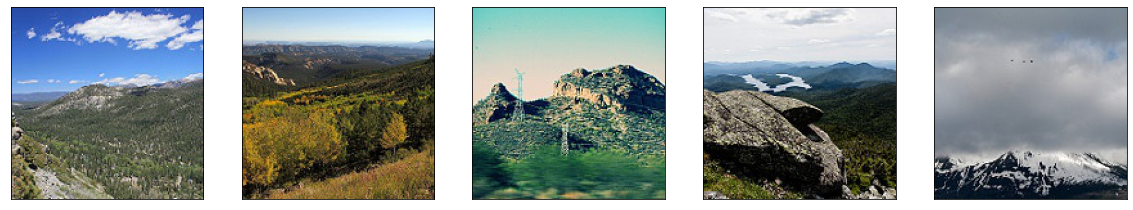

mares


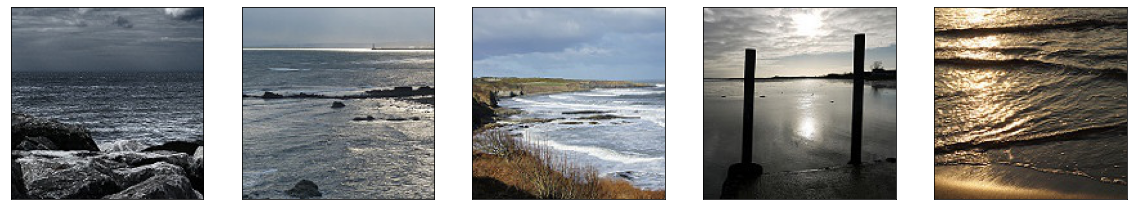

bosques


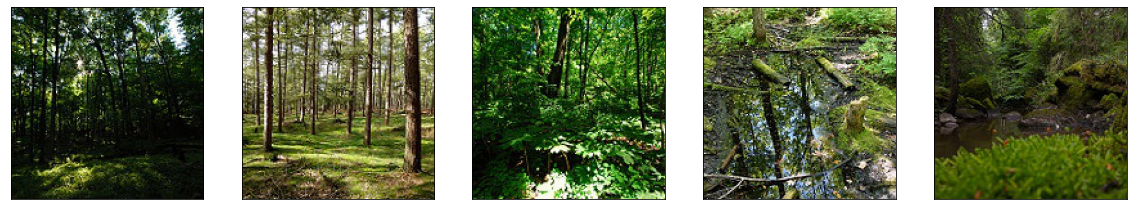

calles


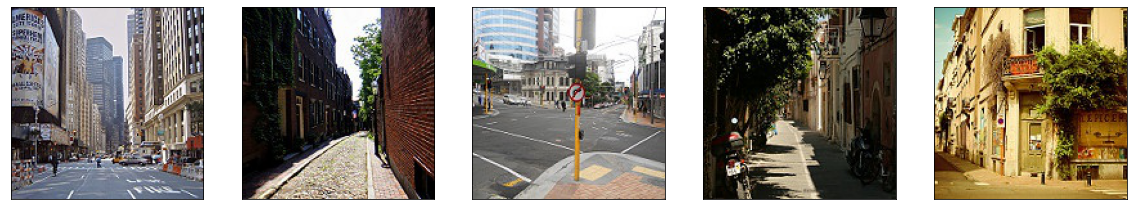

In [5]:
for category in CATEGORIES:
    print(category)
    category_df = dataframes["train"][dataframes["train"]["label"] == category]
    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    for i, index in enumerate(np.random.randint(0, len(category_df), size=(5,))):
        ax[i].imshow(category_df["img"].iloc[index])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

Lo primero que podemos detectar es que hay una imagen con un tamaño distinto al resto en la categoría de `glaciares`. Es algo que tendremos que tratar más adelante. Podemos ver otras cosas, como que el color va a ser un elemento muy relevante a la hora de decidir si la imagen pertenece a `bosques` o a `glaciares`. También vemos que va a ser difícil distinguir entre `montanas` y `glaciares`, y entre `calles` y `edificios`.

### 2.1 Proporción de clases en los datos

Un aspecto importante del que nos tenemos que preocupar es que las clases estén equilibradas en el conjunto de entrenamiento. Una clase demasiado predominante nos puede dar problemas sesgando a los modelos, así que vamos a elaborar gráficos para comprobar si es el caso.

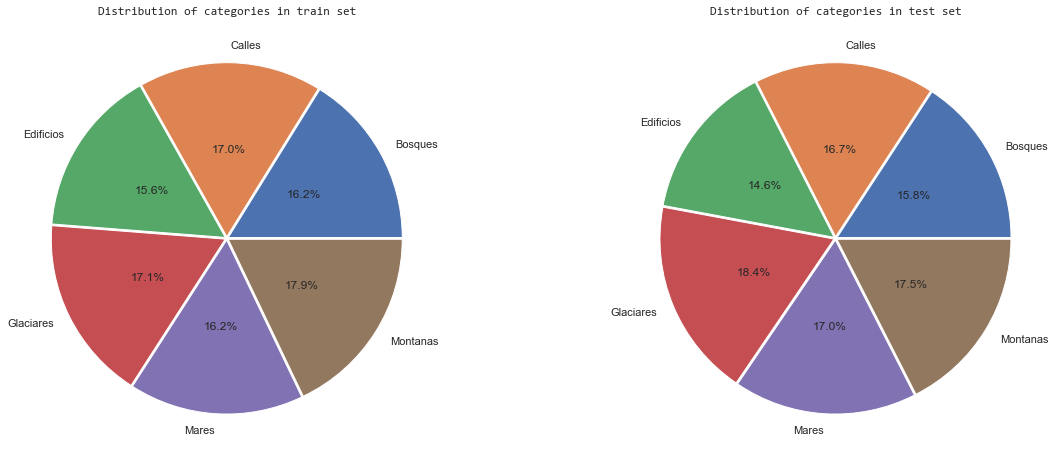

In [18]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i, dataset in enumerate(DATASETS):
    counts = dataframes[dataset]["label"].value_counts()
    counts = {key: val for key, val in sorted(counts.items(), key=lambda x: x[0])}
    ax[i].pie(x=list(counts.values()), autopct="%.1f%%", explode=[0.01]*len(counts), labels=[l.title() for l in counts.keys()], pctdistance=0.5)
    ax[i].set_title(f"Distribution of categories in {dataset} set", fontdict={"size": 14, "font": "Consolas"})

La distribución de las etiquetas es casi uniforme. Esto va a ser muy beneficioso para el entrenamiento.

### 2.2 Tamaños inconsistentes en las imágenes

En el enunciado del problema nos dicen que todas las imágenes tienen un tamaño de 150x150 píxeles. Sin embargo, en una muestra aleatoria que hemos escogido hemos visto una imagen que claramente tiene otro tamaño. Vamos a ver si se da en otros ejemplos.

In [20]:
for dataset in DATASETS:
    print(f"****{dataset.upper()}****")
    for category in CATEGORIES:
        print(f"----{category}----")
        category_df = dataframes["train"][dataframes["train"]["label"] == category]
        for shape in filter(lambda x: x != (150, 150, 3), [x.shape for x in category_df["img"]]):
            print(shape)

****TRAIN****
----edificios----
(124, 150, 3)
----glaciares----
(134, 150, 3)
(123, 150, 3)
(105, 150, 3)
(111, 150, 3)
(135, 150, 3)
(111, 150, 3)
(143, 150, 3)
(97, 150, 3)
(110, 150, 3)
(142, 150, 3)
(76, 150, 3)
(111, 150, 3)
(119, 150, 3)
(146, 150, 3)
(149, 150, 3)
(102, 150, 3)
(120, 150, 3)
----montanas----
(144, 150, 3)
(100, 150, 3)
(131, 150, 3)
(113, 150, 3)
(141, 150, 3)
(135, 150, 3)
(136, 150, 3)
(143, 150, 3)
(144, 150, 3)
(81, 150, 3)
(145, 150, 3)
(134, 150, 3)
(142, 150, 3)
(123, 150, 3)
(103, 150, 3)
(147, 150, 3)
(146, 150, 3)
----mares----
(113, 150, 3)
(140, 150, 3)
(113, 150, 3)
(113, 150, 3)
----bosques----
(113, 150, 3)
(113, 150, 3)
(108, 150, 3)
(135, 150, 3)
(108, 150, 3)
(133, 150, 3)
(115, 150, 3)
(136, 150, 3)
----calles----
(113, 150, 3)
****TEST****
----edificios----
(124, 150, 3)
----glaciares----
(134, 150, 3)
(123, 150, 3)
(105, 150, 3)
(111, 150, 3)
(135, 150, 3)
(111, 150, 3)
(143, 150, 3)
(97, 150, 3)
(110, 150, 3)
(142, 150, 3)
(76, 150, 3)
(111

En todos estos casos nos faltan filas completas de píxeles: el número de columnas siempre es 150 (el esperado) y el número de filas es siempre inferior a 150. Podríamos plantearnos hacer un *padding* y completar estas filas con ceros, pero ya que nos faltan relativamente pocas filas (excepto en unas pocas instancias) podremos simplemente hacer un *resize* al tamaño adecuado.